In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from collections import OrderedDict
import numpy as np
from functools import partial
from tqdm import tqdm
import cv2
from model import VGG19Model

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# Load images and plot them
content_img = Image.open("lilypads2.png").convert("RGB")
style_img = Image.open("monet4.jpg").convert("RGB")

FileNotFoundError: [Errno 2] No such file or directory: 'lilypads2.png'

NameError: name 'content_img' is not defined

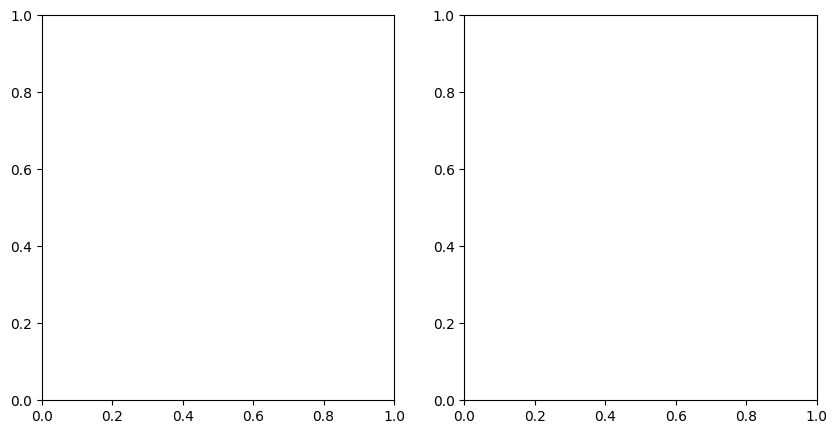

In [5]:
# Plot images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(content_img)
axes[0].axis("off")
axes[0].set_title("Content Image")

axes[1].imshow(style_img)
axes[1].axis("off")
axes[1].set_title("Style Image")

plt.show()

In [5]:
# Define an image transform
transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),  # Convert image to tensor, note that transforms.ToTensor() will scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as expected by VGG
])
content_img = transform(content_img)
style_img = transform(style_img)
print(f"Content img shape {content_img.shape}, Style img shape {style_img.shape}")

Content img shape torch.Size([3, 800, 800]), Style img shape torch.Size([3, 800, 800])


In [6]:
# # Load the model
# class VGG19Model(nn.Module):
#     def __init__(self):
#         super(VGG19Model, self).__init__()
#         self.backbone = torchvision.models.vgg19(pretrained=True).features.eval() # Only use the feature extractor
#         print(self.backbone)

#         # Avoid accidentally training the model
#         for param in self.backbone.parameters():
#             param.requires_grad = False
        
#         # Set the layers to compute style/content losses
#         # self.style_layers = [0, 2, 5, 7]
#         self.style_layers = [0, 5, 10, 19, 28]
#         self.content_layer = 21

#         # Store activations for style layers and content layer
#         self.style_activations = OrderedDict()
#         self.content_activations = None

#         # Register hooks for the forward and back layers
#         self.register_hooks()

#     # Register hooks to get outputs at the content and style layers
#     def register_hooks(self):
#         # We must use partial because if we don't, Python's late binding will make it such that all hooks are registered with the last layer_idx
#         for layer_idx in self.style_layers:
#             self.backbone[layer_idx].register_forward_hook(partial(self.forward_hook, layer_idx=layer_idx, is_style=True))

#         # Only need to register a single layer for the content layer
#         self.backbone[self.content_layer].register_forward_hook(partial(self.forward_hook, layer_idx=self.content_layer, is_style=False))

#     # Hook that keeps track of activations for certain modules
#     def forward_hook(self, module, input, output, layer_idx, is_style):
#         if is_style:
#             self.style_activations[layer_idx] = output
#         else:
#             self.content_activations = output

#     def forward(self, img):
#         self.style_activations = OrderedDict()
#         self.content_activations = None
#         self.backbone(img)
#         return self.content_activations, self.style_activations

In [7]:
def gram_matrix(input_tensor):
    batch_size, num_channels, height, width = input_tensor.shape
    
    # Flatten feature maps into vectors
    features = input_tensor.flatten(start_dim=2)  # Shape is (batch_size, num_channels, height*width)
    
    # Compute Gram matrix w matrix mul
    # Use the pytorch mul operation because the input has the shape B, C, H, W
    # torch.mm only supports 2D matrices
    gram = torch.bmm(features, features.transpose(1, 2))
    
    # Normalise by the number of elements in the feature map
    return gram / (num_channels * height * width * batch_size)

In [8]:
def content_loss(generated_img_maps, target_maps):
    return torch.nn.functional.mse_loss(generated_img_maps, target_maps) / generated_img_maps.numel()

In [9]:
def style_loss(gen_img_style_maps, style_img_maps, layer_weights=None):
    # Initialise layer weights if there are none
    if layer_weights is None:
        layer_weights = {0: 0.2, 2: 0.2, 5: 0.25, 7: 0.25}

    style_loss = 0
    for key in gen_img_style_maps.keys():
        # Get the weight for this layer
        weight = layer_weights.get(key, 1.0)

        # Compute gram matrices for the generated image and the style image
        gen_img_gram = gram_matrix(gen_img_style_maps[key])
        style_img_gram = gram_matrix(style_img_maps[key])
        style_loss += weight * torch.nn.functional.mse_loss(gen_img_gram, style_img_gram)
        # print(torch.nn.functional.mse_loss(gen_img_gram, style_img_gram))
    return style_loss

In [10]:
def tv_loss(img):
    # Compute total variation along width and height dimentions
    # To reduce high-frequency artefacts
    tv_h = torch.sum(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))  # Vertical
    tv_w = torch.sum(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))  # Horizontal
    
    return tv_h + tv_w

In [11]:
# Initialise model
model = VGG19Model().to(device)

# We need to add a batch dimension so that the images can be processed by the model, initialise the images
content_img = content_img.unsqueeze(0).to(device)
style_img = style_img.unsqueeze(0).to(device)
generated_img = content_img.clone().to(device)
# print(generated_img.shape)
# generated_img = torch.randn_like(content_img).to(device).requires_grad_(True)
generated_img.requires_grad = True

/common/home/users/n/nicoleoo.2021/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/common/home/users/n/nicoleoo.2021/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
# Hyperparameters
alpha = 1e3
beta = 5e6
num_iterations = 1500
lr = 0.01
lambda_tv = 1e-6

In [13]:
optimiser = torch.optim.Adam([generated_img], lr=lr)

In [14]:
for i in tqdm(range(num_iterations)):
    content_img_content_feats, content_img_style_feats = model(content_img)
    style_img_content_feats, style_img_style_feats = model(style_img)
    gen_img_content_feats, gen_img_style_feats = model(generated_img)
    
    # Zero the gradient
    optimiser.zero_grad()

    # Calculate the loss
    content_loss_val = content_loss(gen_img_content_feats, content_img_content_feats)
    style_loss_val = style_loss(gen_img_style_feats, style_img_style_feats)
    loss = alpha * content_loss_val + beta * style_loss_val + lambda_tv * tv_loss(generated_img)
    # print(loss)

    # Backprop
    loss.backward()
    optimiser.step()

100%|██████████| 1500/1500 [05:47<00:00,  4.32it/s]


torch.Size([3, 800, 800])
torch.Size([3, 800, 800])
torch.Size([3, 800, 800])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36657605..1.6958245].


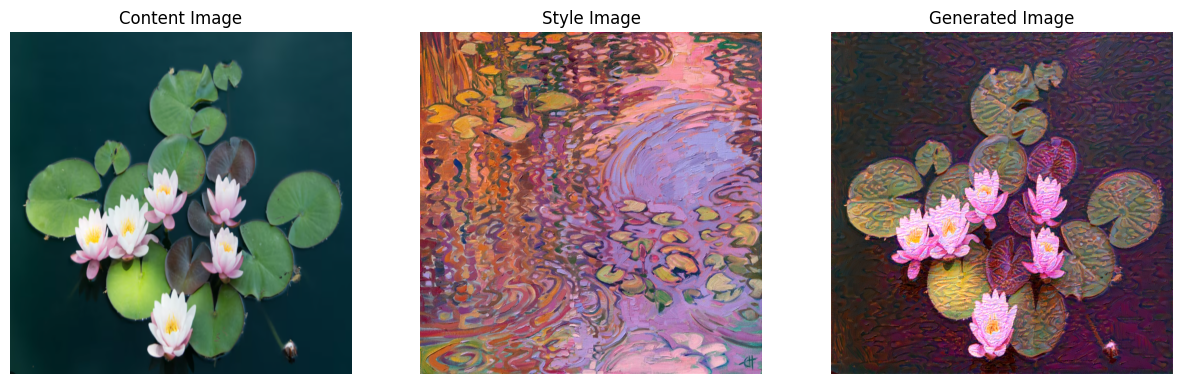

In [15]:
# ImageNet normalisation values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def process_tensor_for_matplotlib(img_tensor):
    img_tensor = img_tensor.permute(1, 2, 0)
    img_tensor = img_tensor.cpu().detach()
    return img_tensor

def denormalise(tensor):
    tensor = tensor.clone()  # Avoid modifying the OG copy
    tensor = tensor.squeeze(0)
    print(tensor.shape)
    # Denormalise the tensor
    for i in range(3):  # RGB 3 channels
        tensor[i] = tensor[i] * std[i] + mean[i]
    
    return tensor

def plot_images(content_img, style_img, generated_img):
    # Denormalise images for viewing
    content_img, style_img, generated_img = denormalise(content_img), denormalise(style_img), denormalise(generated_img)
    
    # First process the images for plotting with matplotlib
    content_img, style_img, generated_img = process_tensor_for_matplotlib(content_img), process_tensor_for_matplotlib(style_img), process_tensor_for_matplotlib(generated_img)

    # Create a row of 3 images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Content Image
    axes[0].imshow(content_img)
    axes[0].axis("off")
    axes[0].set_title("Content Image")

    # Style Image
    axes[1].imshow(style_img)
    axes[1].axis("off")
    axes[1].set_title("Style Image")

    # Generated Image
    axes[2].imshow(generated_img)
    axes[2].axis("off")
    axes[2].set_title("Generated Image")

# Call the function with your images
plot_images(content_img, style_img, generated_img)
plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()